In [1]:
from IPython.core.interactiveshell import InteractiveShell
from IPython.display import display, Markdown, SVG, HTML
import pandas as pd
import altair as alt
import re
import pickle
from utils import seconds_to_ms, ms_to_seconds
from benchmark_result import get_benchmark_results, BenchmarkType, SchedulerType, get_broadcast_source
from benchmarks.utils import echo
from benchmarks.throughput import make_benchmark

In [2]:
#benchmark_results = get_benchmark_results()
from benchmark_result import BenchmarkResult, Result 
with open('saved_results.pkl', 'rb') as saved_results:
    benchmark_results = pickle.load(saved_results)

## ipyparallel benchmark results ##

### time_broadcast

This benchmark comes from benchmaring the runtime of sending and returning different size arrays to different number of engines with the echo function on various scheduler implementations


In [3]:
??echo

Signature: echo(delay=0)
Docstring: <no docstring>
Source:   
def echo(delay=0):
    def inner_echo(x, **kwargs):
        import time

        if delay:
            time.sleep(delay)
        return x

    return inner_echo
File:      ~/ipyparallel_master_project/benchmarks/utils.py
Type:      function


In [4]:
??make_benchmark

Signature: make_benchmark(get_view)
Docstring: <no docstring>
Source:   
def make_benchmark(get_view):
    # @timing_decorator
    class Benchmark(ThroughputSuite):
        params = [
            [0, .1],
            [1, 10, 50, 100, 200],
            [10, 100, 1000, 10_000, 100_000, 1_000_000, 10_000_000],
        ]

        def __init__(self):
            super().__init__()
            self.client = ipp.Client(profile='asv')
            self.view = get_view(self)

        def time_broadcast(self, delay, engines, number_of_bytes):
            self.view.apply_sync(
                echo(delay),
                np.array([0] * number_of_bytes, dtype=np.int8),
                targets=slice(engines),
            )

    return Benchmark
File:      ~/ipyparallel_master_project/benchmarks/throughput.py
Type:      function


### Results from running benchmark on 64 cores


In [5]:
source = get_broadcast_source(benchmark_results)[64]

### Applying echo with a delay of 0:

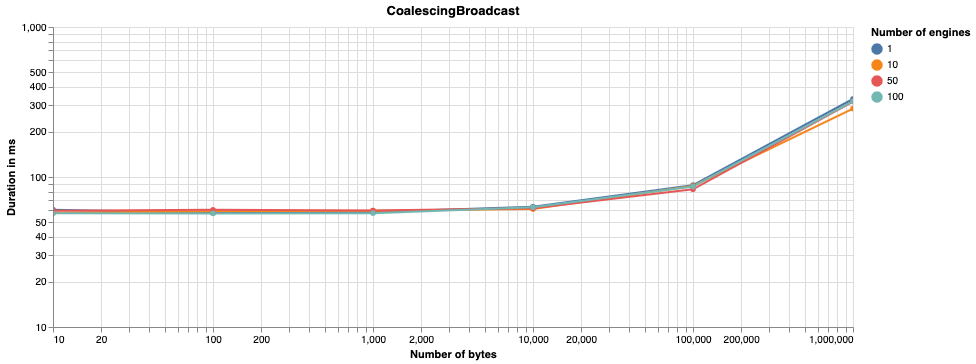

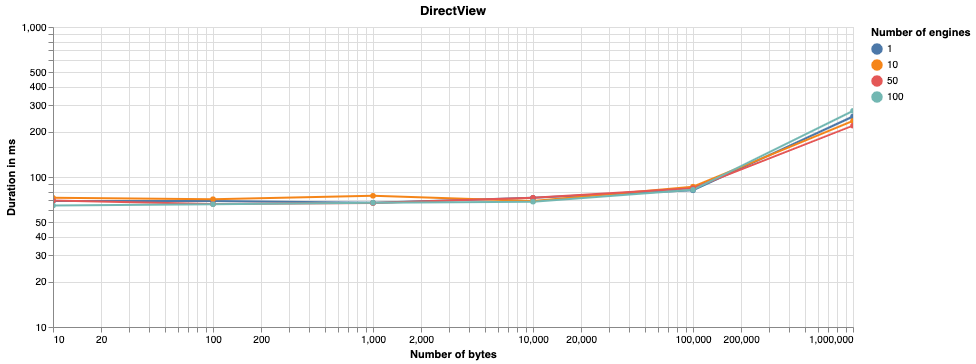

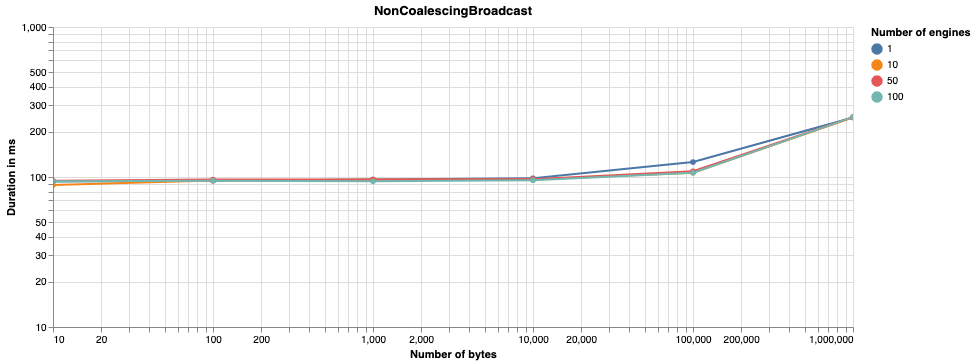

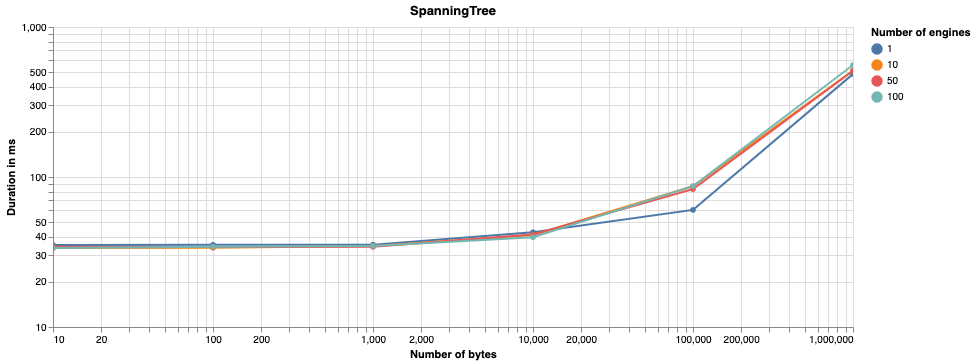

### Applying echo with a delay of 0.1:

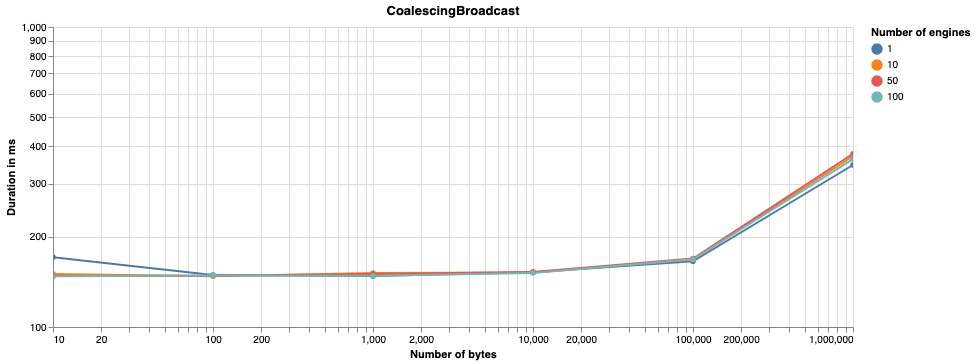

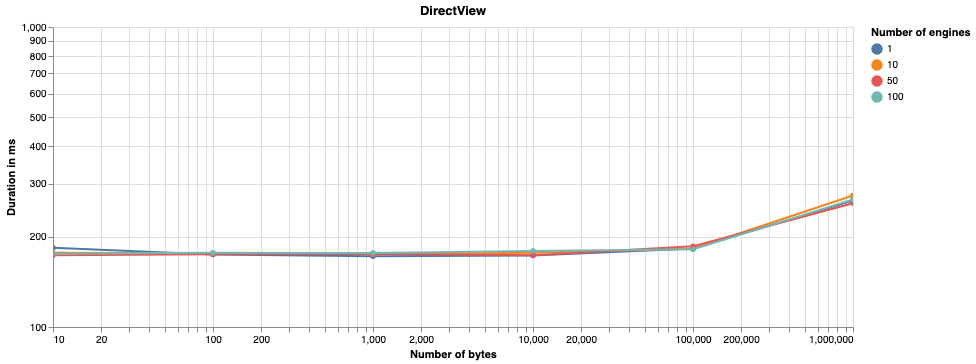

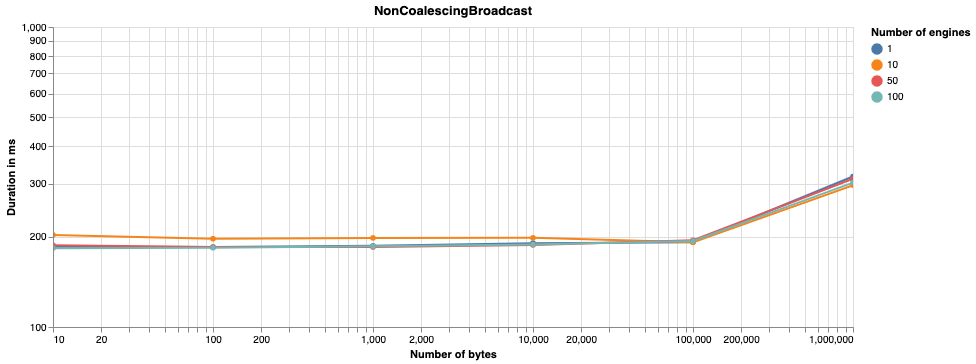

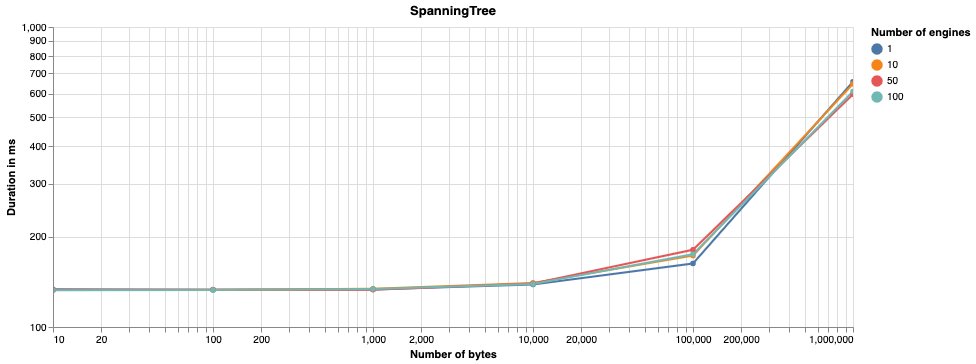

In [9]:
source
for delay, results_for_delay in source.items():
    display(Markdown(f'### Applying echo with a delay of {delay}:'))
    for scheduler_name, scheduler_results in results_for_delay.items():
        data = pd.DataFrame(scheduler_results)
        alt.Chart(data).mark_line(point=True).encode(
            alt.X(
                'Number of bytes',
                scale=alt.Scale(type='log')
            ),
            alt.Y(
                'Duration in ms',
                scale=alt.Scale(type='log')

            ),
            color='Number of engines:N',
            tooltip='Duration in ms',
    
        ).properties(title=scheduler_name, width=800).interactive().display(renderer='svg')
